# Mars Figures de poles
* [Ponctuel](#ponctuel)

## Ponctuel<a name="ponctuel"></a>

rs = chi, and rz = phi, for each  of these positions, we made an omega scan in order to obtain a profile line of the scattered beam. We should have a peak, then we fit this peak with a given function. Then we just need to represent the value of this peak on the pole figuer at the rs, rz coordinate.

In [1]:
%matplotlib notebook

# first the imports
from typing import Iterator, List, NamedTuple, Optional, Text, Tuple

import os

import ipywidgets as widgets
import matplotlib

from matplotlib.pyplot import subplots, show

from numpy import array, ndarray, searchsorted
from h5py import Dataset, File

# local import
from soleil import Angle, Calibrant, Calibration, CalibrationFunctions, CalibrationFrame, DatasetPathContains, DatasetPathWithAttribute, \
    Detector, Length, Parameter, Wavelength, \
    DatasetPath, DatasetPathContains, DatasetPathWithAttribute, get_dataset,\
    calibration, integrate, save_as_edf

In [2]:
# temporary until the ruch is ON
ROOT = os.path.join("/home", "experiences", "instrumentation", "picca", "jupyter", "mars", "20171282")

PUBLISHED = os.path.join(ROOT, "published-data")

In [3]:
# TODO add the data01, 8, 19, 24 a pole for each.
# 1 -> 1 1 0
# 8 -> 2 0 0
# 19 -> 2 2 0
# 24 - > 3 1 0
# a bunch of files seems to contain wrong dataset ???, we mark them as exculded, third member of the tuple

templates = [("Cr7R_T93-02_0p8dpa_text_CR_{}_01.nxs", list(range(164, 405)), [0]),
             #("Cr7R_T93-04_moniteur-thermique-400_C_text_CR_{}_01.nxs", list(range(1101, 1127)), [2, 4]),
             #("Cr7R_T93_reference_text_CR_{}_01.nxs", list(range(656, 907)), [0, 2, 4, 5, 6, 249]),
             #("Cr7V_T134-02_0p8dpa_text_CR_{}_01.nxs", list(range(405, 651)), [1, 3, 4, 5]),
             #("Cr7V_T134_reference_text_CR_{}_01.nxs",list(range(950, 1101)), [21, 22, 24, 28, 30, 54, 56, 57]),
             #("Cr7V_T194-01_0p1dpa_text_CR_{}_01.nxs",list(range(1279, 1299)), []),
             #("Cr7V_T194-01_0p1dpa_Zy-4_text_CR_{}_01.nxs", list(range(1299, 1330)), []),
             #("E59_T029V_text_CR_{}_01.nxs", list(range(1372, 1389)), [])
            ]

PoleSources = NamedTuple('PoleSources', [('filenames', List[Text]),  # name of the files
                                         ('tth_path', DatasetPath),
                                         ('chi_path', DatasetPath),
                                         ('phi_path', DatasetPath),
                                         ('intensity_path', DatasetPath),
                                         ('tth_range', Tuple[float, float])])

def mkPole(template: Tuple[str, List[int]]) -> PoleSources:
    filenames = [os.path.join(ROOT, template[0].format(i)) for ii, i in enumerate(template[1]) if ii not in template[2]]
    tth_path = DatasetPathContains("scan_data/actuator_1_1")
    chi_path = DatasetPathContains("D03-1-CX2__EX__GONIO-MT_Rs__#1/raw_value")
    phi_path = DatasetPathContains("D03-1-CX2__EX__GONIO-MT_Rz__#1/raw_value")
    #intensity_path = DatasetPathContains("scan_data/data_01")
    #tth_range = (40, 47)
    intensity_path = DatasetPathContains("scan_data/data_24")
    tth_range = (46, 51)
    return PoleSources(filenames, tth_path, chi_path, phi_path, intensity_path, tth_range)

poles = [mkPole(t) for t in templates]

In [4]:
PoleFrame = NamedTuple('PoleFrame', [('tth', ndarray),
                                     ('chi', float),
                                     ('phi', float),
                                     ('intensity', ndarray)])

res = []  # List[List[PoleFrame]]

for pole in poles:
    tmp = []
    for filename in pole.filenames:
        with File(filename, mode='r') as f:
            print(filename)
            tth = get_dataset(f, pole.tth_path)[:]
            chi = get_dataset(f, pole.chi_path)[0]
            phi = get_dataset(f, pole.phi_path)[0]
            intensity = get_dataset(f, pole.intensity_path)[:]

            # the fit fnction does not deal properly  with x in decreasing order.
            if tth[-1] < tth[0]:
                tth = tth[::-1]
                intensity = intensity[::-1]

            # keep the data only beetween 40 and 50 tth
            if pole.tth_range is not None:
                imin = searchsorted(tth, pole.tth_range[0])
                imax = searchsorted(tth, pole.tth_range[1])

                tth = tth[imin:imax]
                intensity = intensity[imin:imax]
            
            tmp.append(PoleFrame(tth, chi, phi, intensity))
    res.append(tmp)

/home/experiences/instrumentation/picca/jupyter/mars/20171282/Cr7R_T93-02_0p8dpa_text_CR_165_01.nxs
/home/experiences/instrumentation/picca/jupyter/mars/20171282/Cr7R_T93-02_0p8dpa_text_CR_166_01.nxs
/home/experiences/instrumentation/picca/jupyter/mars/20171282/Cr7R_T93-02_0p8dpa_text_CR_167_01.nxs
/home/experiences/instrumentation/picca/jupyter/mars/20171282/Cr7R_T93-02_0p8dpa_text_CR_168_01.nxs
/home/experiences/instrumentation/picca/jupyter/mars/20171282/Cr7R_T93-02_0p8dpa_text_CR_169_01.nxs
/home/experiences/instrumentation/picca/jupyter/mars/20171282/Cr7R_T93-02_0p8dpa_text_CR_170_01.nxs
/home/experiences/instrumentation/picca/jupyter/mars/20171282/Cr7R_T93-02_0p8dpa_text_CR_171_01.nxs
/home/experiences/instrumentation/picca/jupyter/mars/20171282/Cr7R_T93-02_0p8dpa_text_CR_172_01.nxs
/home/experiences/instrumentation/picca/jupyter/mars/20171282/Cr7R_T93-02_0p8dpa_text_CR_173_01.nxs
/home/experiences/instrumentation/picca/jupyter/mars/20171282/Cr7R_T93-02_0p8dpa_text_CR_174_01.nxs


## plot the spectra

<IPython.core.display.Javascript object>


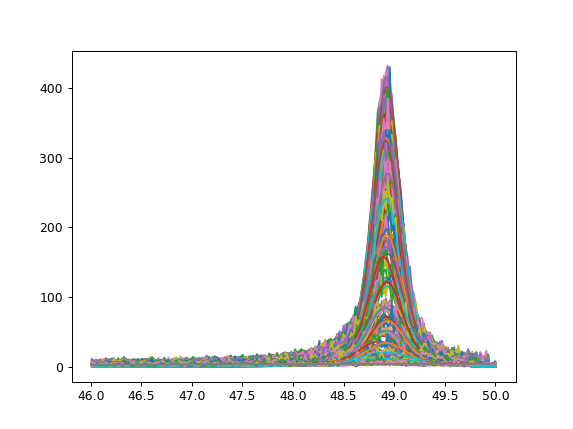

In [5]:
from lmfit.model import ModelResult
from lmfit.models import VoigtModel

model = VoigtModel()


PoleFitFrame = NamedTuple("PoleFitFrame", [("frame", PoleFrame),
                                           ("fit", ModelResult)])


def good(frames: List[PoleFrame]) -> Iterator[PoleFrame]:
    for frame in frames:
        if len(frame.intensity) > 50:
            yield frame

def mkPoleFitFrame(frame: PoleFrame) -> Optional[PoleFitFrame]:
    x = frame.tth
    y = frame.intensity
    
    params = model.guess(y, x=x)
    try:
        # some fit does not work... due to nan values ???
        fit = model.fit(y, params, x=x)
        return PoleFitFrame(frame, fit)
    except ValueError:
        return None

def to_res_fit(res: List[List[PoleFrame]]) -> Iterator[List[PoleFitFrame]]:
    for r in res:
        l = [mkPoleFitFrame(f) for f in r if len(f.tth)]
        l = [e for e in l if e is not None]
        yield l

res_fit = list(to_res_fit(res))


def plot(r: List[List[PoleFitFrame]]) -> None:
# TODO, plot en angles avant de faire les manip de netoyage...
    for r in res_fit:
        fig, ax = subplots()
        for frame, out in r:
            x = frame.tth
            y = frame.intensity

            ax.plot(x, y)
            ax.plot(x, out.best_fit)
    show()

plot(res_fit)

<IPython.core.display.Javascript object>


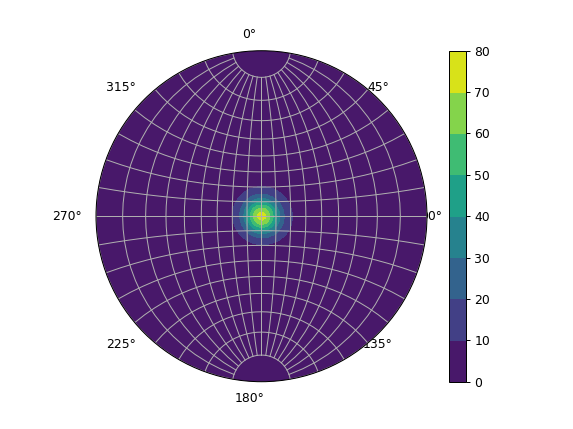

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import mplstereonet

def toStereo(pole: List[PoleFitFrame]) -> (ndarray, ndarray, ndarray):
    phis = []
    chis = []
    w = []
    for frame, fit in pole:
        phis.append(frame.phi)
        chis.append(frame.chi)
        w.append(fit.params['height'].value)
    return (array(phis), array(chis), array(w))

for i, r in enumerate(res_fit):
    fig, ax = mplstereonet.subplots(projection='equal_angle')

    phis, chis, w = toStereo(r)
    cax = ax.density_contourf(phis, chis, measurement='poles', weights=w)

    #ax.pole(phis, chis)
    ax.grid(True)
    fig.colorbar(cax)
    fig.savefig("/tmp/pole_{}.png".format(i))
    plt.show()


## check the peak position  versus phi

<IPython.core.display.Javascript object>


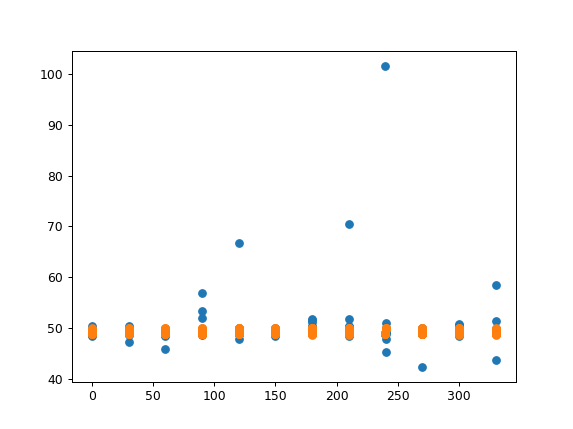

In [7]:
def toCenter(pole: List[PoleFitFrame]) -> (ndarray, ndarray, ndarray):
    phis = []
    centers = []
    maxs = []
    for frame, fit in pole:
        phis.append(frame.phi)
        centers.append(fit.params['center'].value)
        maxs.append(frame.tth[frame.intensity.argmax()])
    return (array(phis), array(centers), array(maxs))

for i, r in enumerate(res_fit):
    fig, ax = subplots()

    phis, centers, maxs = toCenter(r)
    ax.plot(phis, centers, 'o')
    ax.plot(phis, maxs, 'o')
show()

In [8]:
res_fit[0][0].fit.params

Parameters([('center',
             <Parameter 'center', value=48.93064948284823 +/- 0.00197, bounds=[-inf:inf]>),
            ('sigma',
             <Parameter 'sigma', value=0.08331309240439633 +/- 0.00144, bounds=[0.0:inf]>),
            ('amplitude',
             <Parameter 'amplitude', value=108.76726761918317 +/- 1.44, bounds=[-inf:inf]>),
            ('gamma',
             <Parameter 'gamma', value=0.08331309240439633 +/- 0.00144, bounds=[-inf:inf], expr='sigma'>),
            ('fwhm',
             <Parameter 'fwhm', value=0.3000362728068765 +/- 0.00518, bounds=[-inf:inf], expr='3.6013100*sigma'>),
            ('height',
             <Parameter 'height', value=520.8288716266967 +/- 6.89, bounds=[-inf:inf], expr='0.3989423*amplitude/max(1.e-15, sigma)'>)])